<h1>MAGMA vs PascalX</h1>
Notebook investigating discrepancies between gene scoring in MAGMA vs gene scoring in PascalX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from pathlib import Path
import pandas as pd
from scipy.stats import norm, spearmanr

In [2]:
magma_scores_file = Path("../Data/MAGMA/gene_analysis/5,5_window/mono_c/mono_c_merged.txt")
pascalx_scores_file = Path("../Data/PascalX/scores/window_10000/Mono_count_GWAS_gscores.tsv")
monocyte_degs_file = Path("../Data/Reference/monocyte_degs_MONO_CD4.tsv")

In [3]:
new_columns = ['gene', 'chr', 'start', 'stop', 'nsnps', 'nparam', 'n', 'z_stat', 'pvalue']

magma_df = pd.read_csv(magma_scores_file, sep='\s+', header=0, names=new_columns) 
pascalx_df = pd.read_csv(pascalx_scores_file, sep='\t') 
mono_degs_df = pd.read_csv(monocyte_degs_file, sep='\t') 

# Add z_scores for pascalx
def convert_p_to_z(p, min_pvalue=1e-15):
    # If p-value is smaller than the threshold, use the threshold value
    if p < min_pvalue:
        return 10
    try:
        return norm.ppf(1 - p)  # One-tailed transformation
    except Exception as e:
        print(f"Error with p-value: {p}. Exception: {e}")
        return None
        
pascalx_df['z_score'] = pascalx_df["pvalue"].apply(convert_p_to_z)

print(f"MAGMA({len(magma_df)} genes):\n{magma_df.head()}")
print()
print(f"PascalX({len(pascalx_df)} genes):\n{pascalx_df.head()}")

MAGMA(31878 genes):
         gene  chr      start       stop  nsnps  nparam       n   z_stat  \
0  AC239859.3    1  143494187  143505512      2       1  563085 -0.57008   
1  AC239800.2    1  143731066  143744506      1       1  563085 -0.58284   
2  AC239800.3    1  143785010  143802108      1       1  563085  0.27932   
3      NBPF15    1  144416386  144466674     21       3  563085  0.82914   
4     SRGAP2B    1  144882265  145100528     15       8  563085 -0.41696   

    pvalue  
0  0.71569  
1  0.72000  
2  0.39000  
3  0.20351  
4  0.66165  

PascalX(31471 genes):
         gene    pvalue  nsnps  min_pvalue   z_score
0       OR4F5  0.584408      5        0.25 -0.213183
1  AL627309.1  0.066156      3        0.08  1.505044
2  AL627309.3  0.330000      1        0.33  0.439913
3  AL627309.2  0.090000      1        0.09  1.340755
4  AC114498.1  0.210000      1        0.21  0.806421


In [11]:
all_merged_df = pd.merge(pascalx_df, magma_df, how='inner', left_on='gene', right_on='gene', suffixes=('_px', '_mg'))
all_merged_df["delta_p"] = -np.log10(all_merged_df["pvalue_px"]) - (-np.log10(all_merged_df["pvalue_mg"]))
all_merged_df["delta_nsnps"] = all_merged_df["nsnps_mg"] - all_merged_df["nsnps_px"] 
all_merged_df.head()

,gene,pvalue_px,nsnps_px,min_pvalue,z_score,chr,start,stop,nsnps_mg,nparam,n,z_stat,pvalue_mg,delta_p,delta_nsnps
0,OR4F5,0.584408,5,0.25,-0.213183,1,60419,76585,5,2,563085,-0.65611,0.744120,0.104927,0
1,AL627309.1,0.066156,3,0.08,1.505044,1,84295,138723,2,1,563085,1.37650,0.084335,0.105436,-1
2,AL627309.2,0.090000,1,0.09,1.340755,1,134790,145339,1,1,563085,1.34080,0.090000,0.000000,0
3,AC114498.1,0.210000,1,0.21,0.806421,1,582629,599768,3,2,563085,0.72952,0.232840,0.044838,2
4,OR4F16,0.180000,1,0.18,0.915365,1,680679,691673,2,1,563085,0.23525,0.407010,0.354333,1


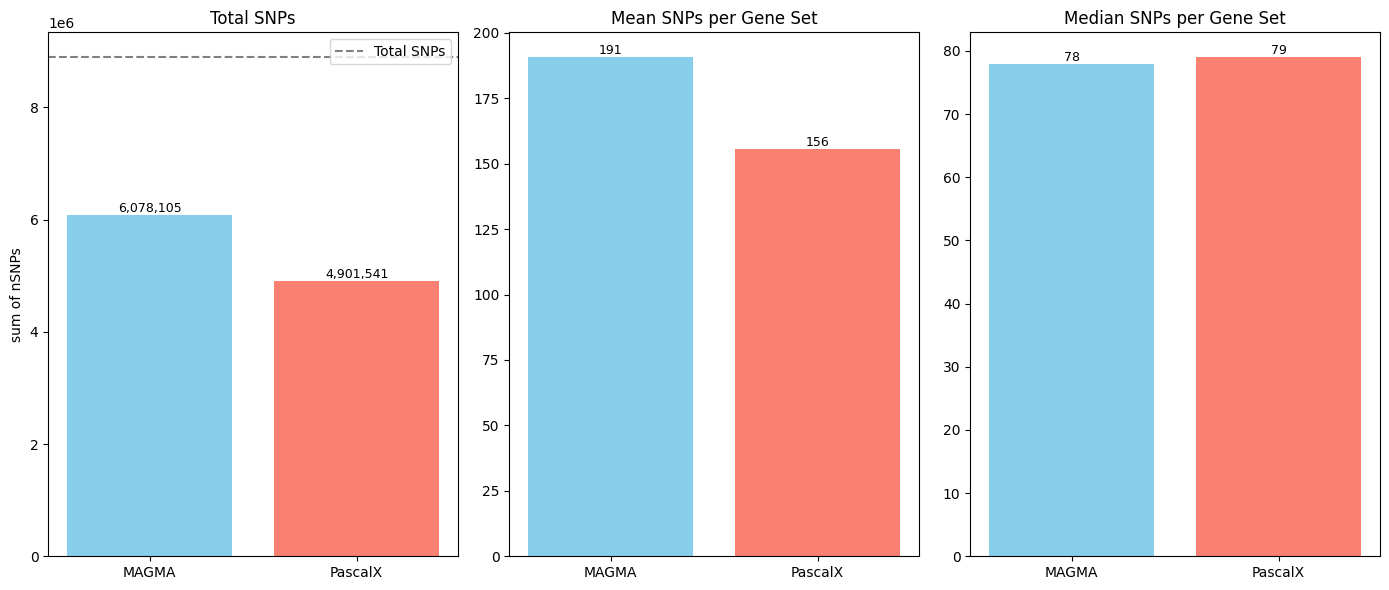

In [9]:
methods = ['MAGMA', 'PascalX']

# Total SNPs
snp_counts = [magma_df["nsnps"].sum(), pascalx_df["nsnps"].sum()]
total_snps = 8893396

# Mean SNPs
mean_snp_counts = [magma_df["nsnps"].mean(), pascalx_df["nsnps"].mean()]

# Median SNPs
median_snp_counts = [magma_df["nsnps"].median(), pascalx_df["nsnps"].median()]

# Create 3 horizontal subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# --- Total SNPs Plot ---
bars = axs[0].bar(methods, snp_counts, color=['skyblue', 'salmon'])
axs[0].axhline(y=total_snps, color='gray', linestyle='--', label='Total SNPs')

for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}',
                ha='center', va='bottom', fontsize=9)

axs[0].set_ylabel("sum of nSNPs")
axs[0].set_title("Total SNPs")
axs[0].legend()

# --- Mean SNPs Plot ---
bars2 = axs[1].bar(methods, mean_snp_counts, color=['skyblue', 'salmon'])

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}',
                ha='center', va='bottom', fontsize=9)

axs[1].set_title("Mean SNPs per Gene Set")

# --- Median SNPs Plot ---
bars3 = axs[2].bar(methods, median_snp_counts, color=['skyblue', 'salmon'])

for i, bar in enumerate(bars3):
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}',
                ha='center', va='bottom', fontsize=9)

axs[2].set_title("Median SNPs per Gene Set")

# Layout
plt.tight_layout()
plt.show()


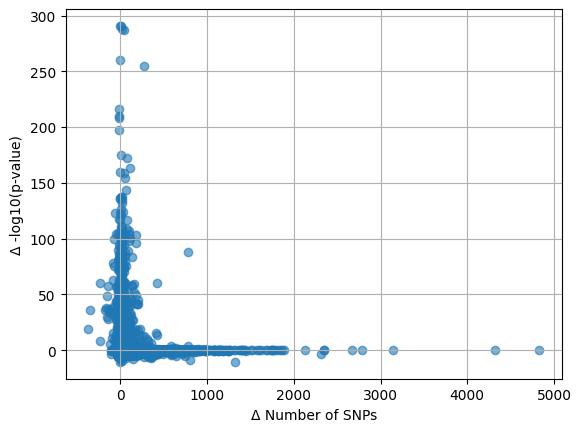

Differently assigned genes: 30777


In [14]:
delta_nsnp = all_merged_df["delta_nsnps"]
delta_p = all_merged_df["delta_p"]
plt.scatter(delta_nsnp, delta_p, alpha=0.6)
plt.xlabel("Δ Number of SNPs")
plt.ylabel("Δ -log10(p-value)")
plt.grid(True)
plt.show()
print("Differently assigned genes:", (delta_nsnp != 0).sum())

In [12]:
px_genes = pascalx_df["gene"].tolist()
missing_genes_df = magma_df[~magma_df["gene"].isin(px_genes)].copy()
missing_gene_names = missing_genes_df["gene"]
print(missing_genes_df["chr"].unique())

[ 1 14  2 16  9 19 22 11 17  7 15 21 10 18  8  6]


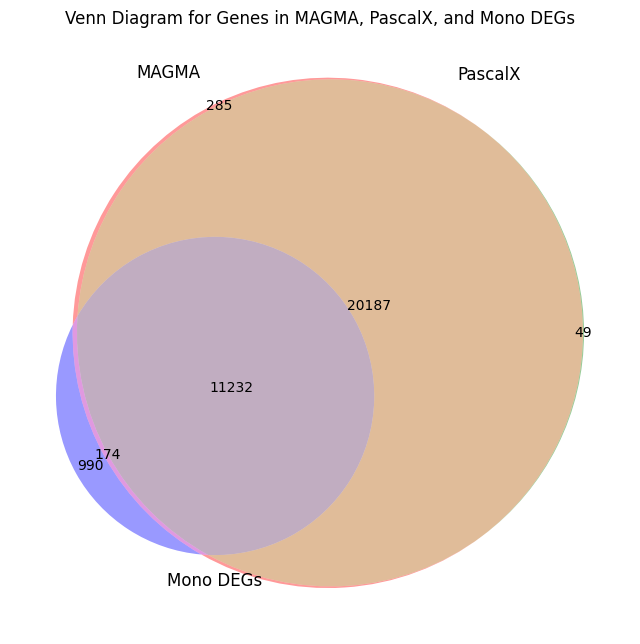

In [84]:
magma_genes = set(magma_df['gene'])
pascalx_genes = set(pascalx_df['gene'])
mono_degs_genes = set(mono_degs_df['names'])

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3([magma_genes, pascalx_genes, mono_degs_genes],
             set_labels=('MAGMA', 'PascalX', 'Mono DEGs'))

# Customize the plot (optional)
plt.title("Venn Diagram for Genes in MAGMA, PascalX, and Mono DEGs")

# Show the plot
plt.show()


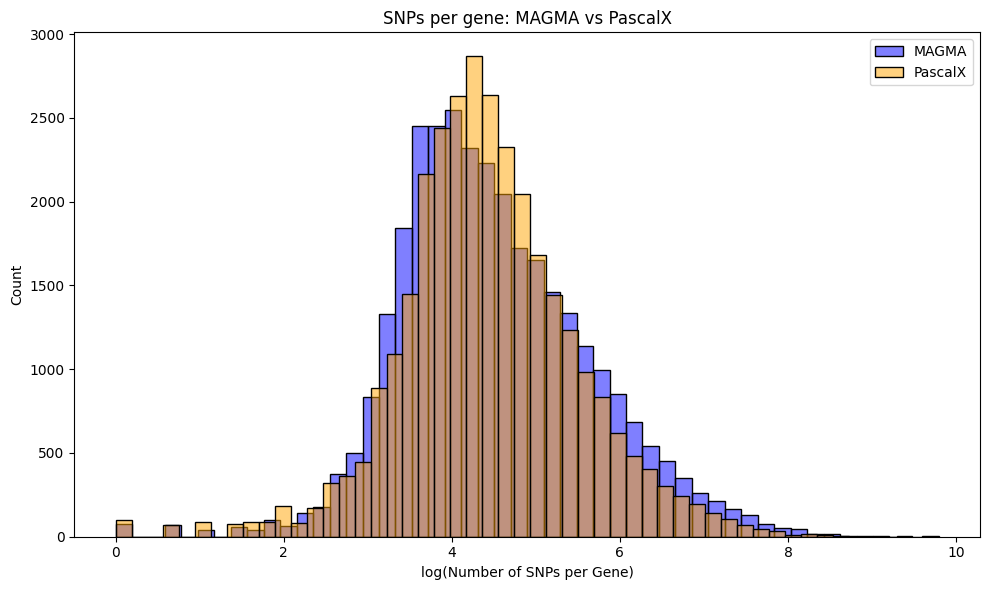

In [49]:
plt.figure(figsize=(10, 6))

sns.histplot(np.log(magma_df['nsnps']), bins=50, color='blue', label='MAGMA', alpha=0.5)
sns.histplot(np.log(pascalx_df['nsnps']), bins=50, color='orange', label='PascalX', alpha=0.5)

plt.xlabel('log(Number of SNPs per Gene)')
plt.ylabel('Count')
plt.title('SNPs per gene: MAGMA vs PascalX')
plt.legend()
plt.tight_layout()
plt.show()

<h2>Top 1000 genes</h2>

In [17]:
# Top genes basedn on P-value
top_mg_p = magma_df.nsmallest(1000, 'pvalue')[["gene", "z_stat", "pvalue", "nsnps"]]
top_px_p = pascalx_df.nsmallest(1000, 'pvalue')[["gene", "z_score", "pvalue", "nsnps"]]

# Top genes based on Z-score
top_mg_z = magma_df.nlargest(1000, 'z_stat')[["gene", "z_stat", "pvalue", "nsnps"]]
top_px_z = pascalx_df.nlargest(1000, 'z_score')[["gene", "z_score", "pvalue", "nsnps"]]

top_degs = mono_degs_df.head(1000)

print(top_px_p.head())
print(top_mg_p.head())

             gene  z_score         pvalue  nsnps
6399    LINC01565     10.0  1.000000e-300     57
6400         RPN1     10.0  1.000000e-300    195
24996        IRF8     10.0  1.000000e-300    133
24997  AC092723.5     10.0  1.000000e-300    210
24999  AC092723.4     10.0  3.740108e-275    164
              gene  z_stat        pvalue  nsnps
28715       CCDC26  13.267  1.810400e-40   3412
4394   MIR4435-2HG  13.111  1.428500e-39   1134
1756        STXBP6  10.707  4.701800e-27    840
24232       TGFBR3  10.607  1.385500e-26    796
12410    LINC00598  10.606  1.390400e-26   1590


**Check p-val and z-score genes are the same**

In [65]:
# Top 1000 based on p-value
top_mg_p_genes = top_mg_p['gene'].tolist()
top_px_p_genes = top_px_p['gene'].tolist()

# Top 1000 based on Z-statistic (Z-score)
top_mg_z_genes = top_mg_z['gene'].tolist()
top_px_z_genes = top_px_z['gene'].tolist()

# Genes in both p-value and Z-score lists
common_mg_genes = set(top_mg_p_genes).intersection(top_mg_z_genes)
common_px_genes = set(top_px_p_genes).intersection(top_px_z_genes)

# Genes only in p-value or Z-score list (exclusive)
unique_mg_p_genes = set(top_mg_p_genes) - set(top_mg_z_genes)
unique_mg_z_genes = set(top_mg_z_genes) - set(top_mg_p_genes)

unique_px_p_genes = set(top_px_p_genes) - set(top_px_z_genes)
unique_px_z_genes = set(top_px_z_genes) - set(top_px_p_genes)

# Output the results
print(f"Common Genes in MAGMA (p-value and Z-score): {len(common_mg_genes)}")
print(f"Common Genes in PascalX (p-value and Z-score): {len(common_px_genes)}")

print(f"Unique MAGMA Genes (p-value only): {len(unique_mg_p_genes)}")
print(f"Unique MAGMA Genes (Z-score only): {len(unique_mg_z_genes)}")

print(f"Unique PascalX Genes (p-value only): {len(unique_px_p_genes)}")
print(f"Unique PascalX Genes (Z-score only): {len(unique_px_z_genes)}")


Common Genes in MAGMA (p-value and Z-score): 1000
Common Genes in PascalX (p-value and Z-score): 1000
Unique MAGMA Genes (p-value only): 0
Unique MAGMA Genes (Z-score only): 0
Unique PascalX Genes (p-value only): 0
Unique PascalX Genes (Z-score only): 0


**SNPs per gene** 

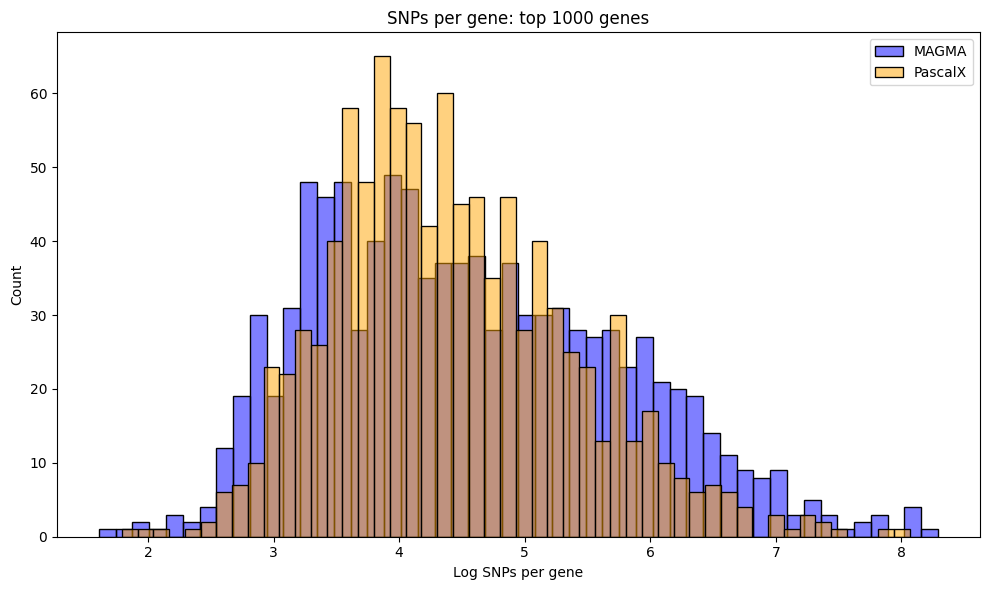

In [18]:
plt.figure(figsize=(10, 6))

sns.histplot(np.log(top_mg_p['nsnps']), bins=50, color='blue', label='MAGMA', alpha=0.5)
sns.histplot(np.log(top_px_p['nsnps']), bins=50, color='orange', label='PascalX', alpha=0.5)

plt.xlabel('Log SNPs per gene')
plt.ylabel('Count')
plt.title('SNPs per gene: top 1000 genes')
plt.legend()
plt.tight_layout()
plt.show()

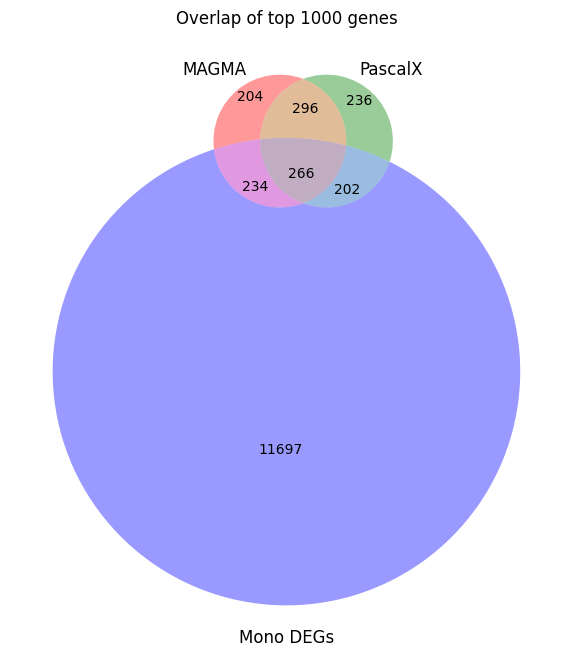

In [17]:
magma_genes = set(top_mg_p['gene'])
pascalx_genes = set(top_px_p['gene'])
# mono_degs_genes = set(top_degs['names'])
mono_degs_genes = set(mono_degs_df['names'])
# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3([magma_genes, pascalx_genes, mono_degs_genes],
             set_labels=('MAGMA', 'PascalX', 'Mono DEGs'))

# Customize the plot (optional)
plt.title("Overlap of top 1000 genes")

# Show the plot
plt.show()

In [20]:
t1k_merged_df = pd.merge(top_px_p, top_mg_p, how='inner', left_on='gene', right_on='gene', suffixes=('_px', '_mg'))
t1k_merged_df["delta_p"] = -np.log10(t1k_merged_df["pvalue_px"]) - (-np.log10(t1k_merged_df["pvalue_mg"]))
t1k_merged_df["delta_nsnps"] = t1k_merged_df["nsnps_mg"] - t1k_merged_df["nsnps_px"] 
print(len(t1k_merged_df))
print(t1k_merged_df.head())

562
         gene  z_score      pvalue_px  nsnps_px  z_stat     pvalue_mg  \
0        RPN1     10.0  1.000000e-300       195  7.2586  1.956200e-13   
1  AC092723.5     10.0  1.000000e-300       210  7.1343  4.863900e-13   
2  AC092723.4     10.0  3.740108e-275       164  7.6303  1.171300e-14   
3  AL162414.1     10.0  3.520168e-267       375  7.0458  9.216700e-13   
4   LINC02132     10.0  1.642612e-222       124  7.6094  1.376700e-14   

   nsnps_mg     delta_p  delta_nsnps  
0       241  287.291413           46  
1       226  287.686985           16  
2       165  260.495784            1  
3       650  254.418012          275  
4       104  207.923304          -20  


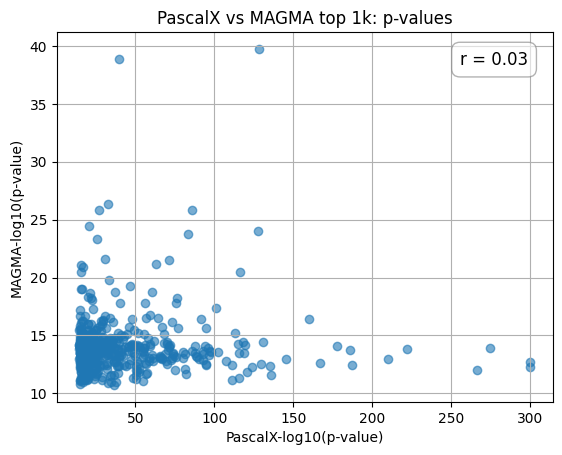

In [52]:
p_px = -np.log10(t1k_merged_df["pvalue_px"])
p_mx = -np.log10(t1k_merged_df["pvalue_mg"])
plt.scatter(p_px, p_mx, alpha=0.6)
plt.title("PascalX vs MAGMA top 1k: p-values")
plt.xlabel("PascalX-log10(p-value)")
plt.ylabel("MAGMA-log10(p-value)")
correlation = p_px.corr(p_mx)
plt.grid(True)
# Add correlation coefficient annotation
plt.text(0.95, 0.95, f'r = {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='right', 
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.5'))

plt.show()

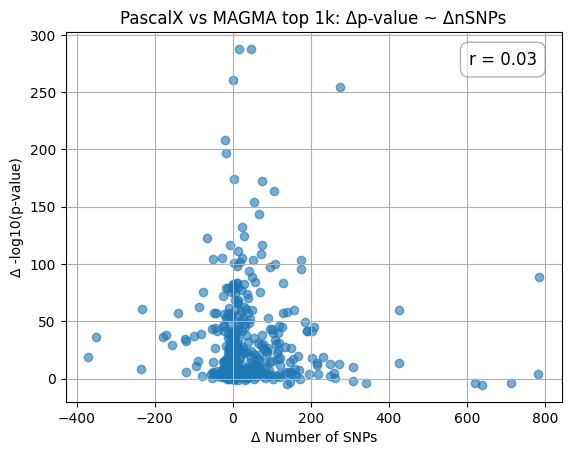

In [54]:
delta_nsnp = t1k_merged_df["delta_nsnps"]
delta_p = t1k_merged_df["delta_p"]
plt.scatter(delta_nsnp, delta_p, alpha=0.6)
plt.title("PascalX vs MAGMA top 1k: Δp-value ~ ΔnSNPs")
plt.xlabel("Δ Number of SNPs")
plt.ylabel("Δ -log10(p-value)")
correlation = delta_nsnp.corr(delta_p)
plt.grid(True)
# Add correlation coefficient annotation
plt.text(0.95, 0.95, f'r = {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='right', 
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.5'))
plt.show()

In [24]:
print("Pearson corr:", delta_nsnp.corr(delta_p))

Pearson corr: 0.031497016753158025


In [51]:
delta_p.min()

-5.485160118593118